## Search for multiple planet signals in simulated time-series, including a known transiting planet

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
from ffper import extract_activity_basis, construct_basis, fit_basis, run_l1_periodogram

In [3]:
from scipy.io import readsav

### Read in the data 

This is a simulated time-series from Meunier et al. (2023) consisting of 1000 observations of a G2 star spread over 10 years. Each observation consists of time (in days), log R'_HK and RV (in m/s). This dataset contains no injected planets.

In [4]:
fl = 'example_no_planet.sav'
d = readsav(fl)
x = np.array(d['tt']).flatten()
y = np.array(d['rv']).flatten()
# y = np.random.normal(0, 0.09, len(x))
z = np.array(d['ca']).flatten()
y_sig = np.zeros_like(y) + 0.09 # see M+23, section 2.1.3
z_sig = np.zeros_like(z) + 5e-4 # see M+23, section 2.1.3

We will select the first 4 of 10 seasons only, to make it run faster. If you want to model the full dataset, skip the cell below or modify `S_MAX`

In [5]:
S_MAX = 4
s = np.floor((x-min(x)+30) / 365).astype(int)
l = s < S_MAX
x = x[l]
y = y[l]    
y_sig = y_sig[l]
z = z[l]
z_sig = z_sig[l]

### Model activity time-series

In this step we decompose the activity time-series (log R'_HK in this case) into a long-term compoment, and a short-term one. 

If the time-series is longer than 8 seasons, the long-term component is estimated as follows. We compute a Lomb-Scargle periodogram for periods longer than 100 days, with `nterms=3` which means that at each trial period the model consists of 3 sinusoidal terms, one at the period in question, one at its first harmonic, and one at its second harmonic. The long-term compoment is then taken to be the best-fitting LS model. If the time-series is shorter than 8 seasons, the long-term component is modelled simply as a 2nd order polynomial.

This long-term component is the subtracted from the activity time-series, and we move to modelling the rotational component of the activity signal. First, we compute a Lomb-Scargle periodogram for each season of data, this time with `nterms=1` (no harmonics). The peak in the periodograms averaged over all the seasons is used as a first guess for the rotation period. Then, we model the long-term-corrected activity time-series with a quasi-periodic GP, fitting for the hyper-parameters (variance, period, harmonic complexity, evolutionary timescale). Finally, we evaluate the predictive mean of the GP and its time derivative, season by season, and these consistitute the remaining 2 components of the activity model we will fit to the RVs

Rotation period = 22.085 days
Activity cycle period = -1.000 days


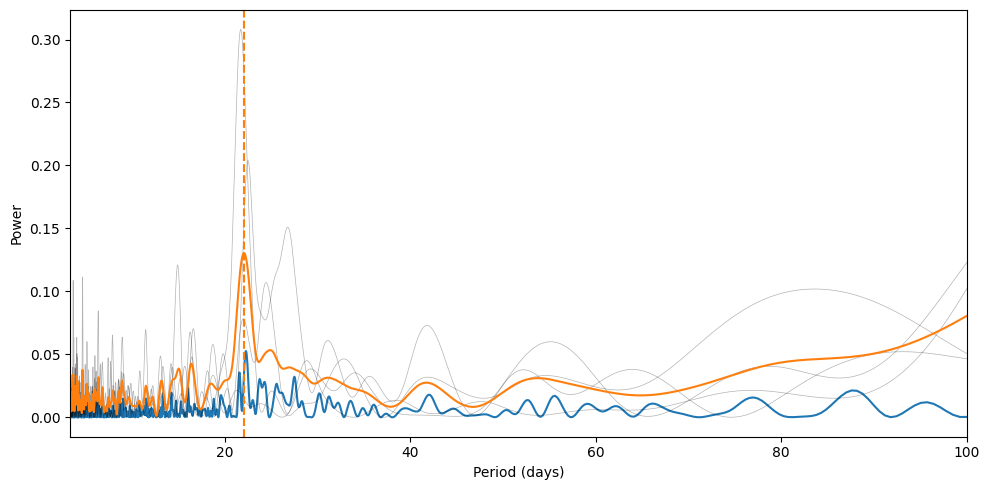

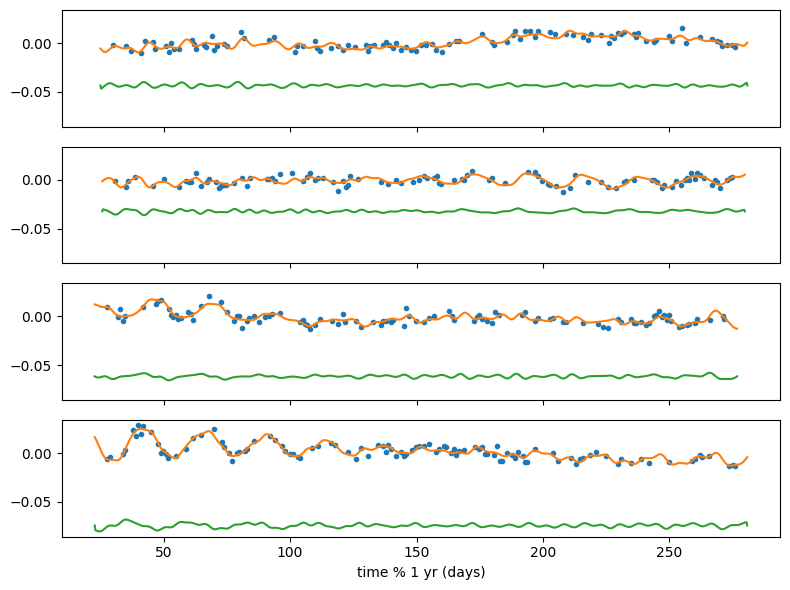

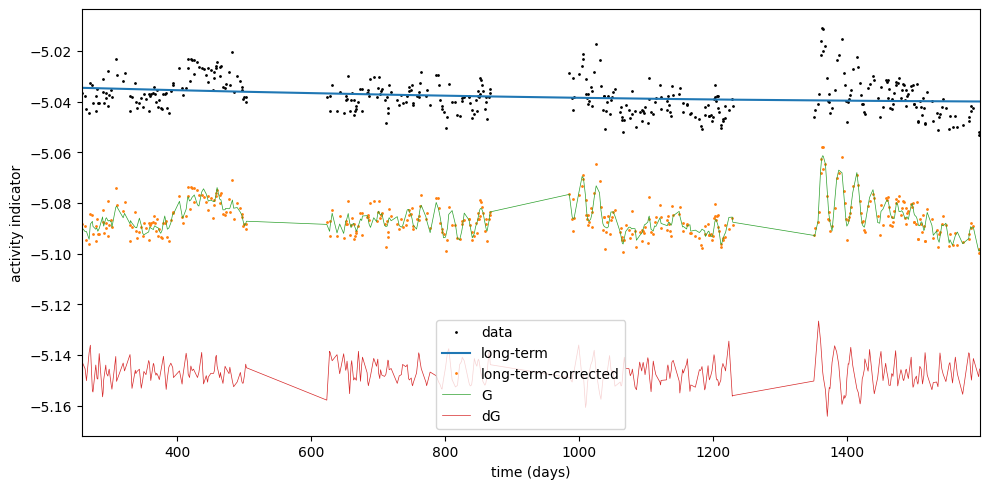

In [6]:
activity_terms, activity_periods, GP_par, activity_figures = \
    extract_activity_basis(x, z, zerr = z_sig,
                           do_plot = True, verbose = False)
per_cyc, per_rot = activity_periods
print(f'Rotation period = {per_rot:.3f} days')
print(f'Activity cycle period = {per_cyc:.3f} days')

Of the 3 plots produced by the cell above:
- the first figure shows the LS periodogram of the long-term-corrected activity time-series. The periodogram of the full dataset is shown in blue, those for each season are shown by the thin grey lines, and the average over all seasons is in orange. The vertical dashed orange line shows the estimated stellar rotation period. If the dataset was long enough, the figure has an additional panel on the right showing the LS periodogram of the original activity time-series (in blue) evaluated for periods longer than 100 days, with the estimated activity cycle period shown by the green vertical dashed line.
- the second figure shows the season-by-season GP fit to the long-term-corrected actiity time-series, with the data in blue, the GP mean in orange, and its time-derivative in green (shown re-scaled and with a vertical offset for clarity).
- the third figure shows the activity time-series in black with the long-term component in blue, then below that the long-term-corrected actibity time-series in orange with the GP predictive mean ("G" in the multi-GP formalism) in green, and below that its time-derivative (dG in the multi-GP formalism) in red. 

### Inject planetary signals

Since the simulated time-series didn't contain a planetary signal, let's inject some. First the transiting planet(s), which are specified using the period and the time of transit centre.

In [7]:
transiting_planets = [[61.379,14.65],[801.54,256.0]]
transit_amps = [0.334,0.367]
n_trpl = len(transiting_planets)
y_pl = np.zeros(len(y))
for i in range(n_trpl):
    per, tc = transiting_planets[i]
    y_pl -= transit_amps[i] * np.sin(2 * np.pi * (x - tc) / per)

Now add the "unknown" planet(s)

In [8]:
per_inj = [302.80, 16.43] 
amp_inj = [1.78, 0.508]
pha_inj = [0.75, 0.253]
n_ukpl = len(per_inj)
for i in range(n_ukpl):
    y_pl += amp_inj[i] * np.cos(2 * np.pi * (x / per_inj[i] - pha_inj[i]))


### Search for planetary signals

To this end we follow the same procedure as in the single planet search example (where we also addressed the question of whether we get a false alarm in the planet-free dataset)

In this example, however, there are two differences. 
- First we have a known transiting planet, which we include in the unpenalised basis terms.
- Second, we are looking for an unknown number of signals so we let `n_pl_eval_max=5`, and set the `fap_threshold` parameter to -2 to keep only significant (FAP <= 1%) peaks.

In [9]:
Basis = construct_basis(x, activity_terms, transiting_planets)
periods, faps = run_l1_periodogram(x, y+y_pl, s, y_sig, basis = Basis, 
                                   sig_add_w = 0.0, fap_threshold = 0.01, 
                                   n_pk_eval_max = 5)

Maximum number of iterations reached in lars, exit


In [10]:
n_detpl = len(periods)
print('Detected:')
for i in range(n_detpl):
    print(f'Detected period = {periods[i]:.3f} days, log10(FAP) = {faps[i]:.2f}')
print('Injected:')
for i in range(n_ukpl):
    print(f'Injected period = {per_inj[i]:.3f} days')


Detected:
Detected period = 299.553 days, log10(FAP) = -152.35
Detected period = 16.428 days, log10(FAP) = -61.38
Injected:
Injected period = 302.800 days
Injected period = 16.430 days


Ok so it looks like the injected periods were both found. That's a good start.

### Perform final fit

Now we know have detected some non-transiting planet candidates, we want to estimate their amplitudes and phases, as well as the amplitudes of the transiting planet signals. To do this we add a sine and a cosine at the period of the new candidate planets to the basis, and fit the linear basis model to RV data 

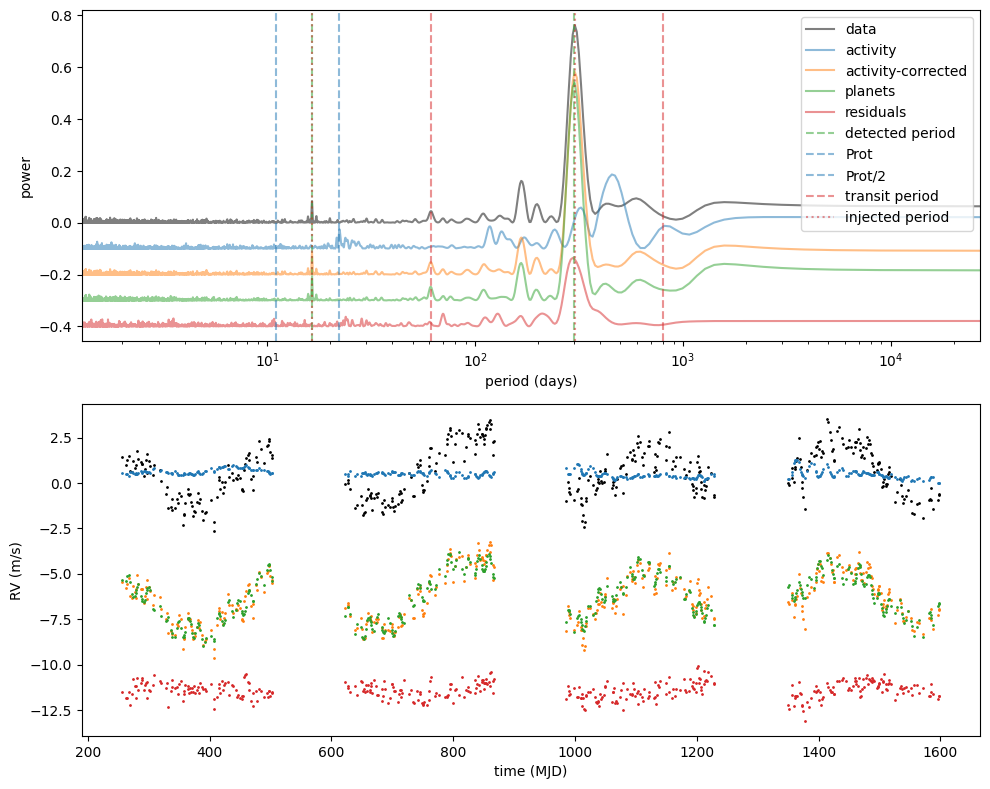

In [11]:
Basis = construct_basis(x, activity_terms, transiting_planets, periods)
resid, coeff, fit_figure = fit_basis(x, y+y_pl, y_sig, Basis, 
                                     do_plot = True, verbose = False)

# Add vertical lines to periodogram in figure 
per_cyc, per_rot = activity_periods
plt.figure(fit_figure.number)
plt.sca(plt.gcf().axes[0])
for i in range(n_detpl):
    if i == 0:
        plt.axvline(periods[i], color = 'C2', ls = 'dashed', alpha = 0.5, label = 'detected period')
    else:
        plt.axvline(periods[i], color = 'C2', ls = 'dashed', alpha = 0.5)
plt.axvline(per_rot, color = 'C0', ls = 'dashed', alpha = 0.5, label = 'Prot')
plt.axvline(per_rot/2, color = 'C0', ls = 'dashed', alpha = 0.5, label = 'Prot/2')
if per_cyc>0:
    plt.axvline(per_cyc, color = 'C0', ls = 'dotted', alpha = 0.5, label = 'Pcyc')
for i in range(n_trpl):
    if i == 0:
        plt.axvline(transiting_planets[i][0], color = 'C3', ls = 'dashed', alpha = 0.5, label = 'transit period')
    else:
        plt.axvline(transiting_planets[i][0], color = 'C3', ls = 'dashed', alpha = 0.5)

for i in range(n_ukpl):
    if i == 0:
        plt.axvline(per_inj[i], color = 'C3', ls = 'dotted', alpha = 0.5, label = 'injected period')
    else:
        plt.axvline(per_inj[i], color = 'C3', ls = 'dotted', alpha = 0.5)
plt.legend(loc=0);

Ok so did we get the right amplitude?

In [12]:
for i in range(n_trpl):
    print(f'Transiting planet with period {transiting_planets[i][0]:.3f} recovered with amplitude {coeff[4+i]:.2f} m/s (true value {transit_amps[i]:.2f} m/s)')
x_mid = 0.5 * (x.max() + x.min())
for i in range(n_detpl):
    amp = np.sqrt(coeff[4+n_trpl+i]**2 + coeff[5+n_trpl+i]**2) 
    pha = np.arctan2(coeff[4+n_trpl+i], coeff[5+n_trpl+i]) / np.pi /2
    if pha < 0:
        pha += 1
    print(f'Non-transiting planet candidate with period {periods[i]:.3f} found with amplitude {amp:.2f} m/s and phase {pha:.2f}')
for i in range(n_ukpl):
    ph_inj = (x_mid / per_inj[i] + pha_inj[i]) % 1
    print(f'Non-transiting planet injected with period {per_inj[i]:.3f}, amplitude {amp_inj[i]:.2f} m/s and phase {pha_inj[i]:.2f}')

Transiting planet with period 61.379 recovered with amplitude 0.33 m/s (true value 0.33 m/s)
Transiting planet with period 801.540 recovered with amplitude 0.35 m/s (true value 0.37 m/s)
Non-transiting planet candidate with period 299.553 found with amplitude 1.76 m/s and phase 0.80
Non-transiting planet candidate with period 16.428 found with amplitude 0.52 m/s and phase 0.25
Non-transiting planet injected with period 302.800, amplitude 1.78 m/s and phase 0.75
Non-transiting planet injected with period 16.430, amplitude 0.51 m/s and phase 0.25


Not too bad!